In [13]:
# from google.colab import drive
# drive.mount('/content/drive')

In [14]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [15]:
"""Colab Drive Path"""
# train_dir = "/content/drive/MyDrive/DEPI_Graduation_Project/Dataset/train"
# val_dir   = "/content/drive/MyDrive/DEPI_Graduation_Project/Dataset/val"
# test_dir  = "/content/drive/MyDrive/DEPI_Graduation_Project/Dataset/test"

"""Local Path"""
train_dir = "Dataset/train"
val_dir   = "Dataset/val"
test_dir =  "Dataset/test"

In [16]:
# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=64,
    seed=111,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=64,
    seed=111,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=64,
    seed=111,
    shuffle=False
)

Found 14000 files belonging to 10 classes.
Found 3000 files belonging to 10 classes.
Found 3000 files belonging to 10 classes.


In [17]:
# Shape of Images and labels in one batch
for images, labels in train_ds.take(1):
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)


Images batch shape: (64, 224, 224, 3)
Labels batch shape: (64,)


In [18]:
# Class Names
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


In [19]:
def segment_hand(image):
    """
    Apply grayscale threshold segmentation (Otsu’s method).
    """
    # Convert TensorFlow tensor → NumPy array
    if not isinstance(image, np.ndarray):
        image = image.numpy()

    # Scale to [0,255] and convert to uint8
    if image.max() <= 1.0:
        img = (image * 255).astype("uint8")
    else:
        img = image.astype("uint8")

    # Ensure the image is grayscale
    if img.ndim == 3 and img.shape[-1] == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img

    # Otsu’s threshold
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply mask to the images
    segmented = cv2.bitwise_and(img, img, mask=mask)

    return segmented

In [20]:
def tf_segment_hand(x):
    return tf.py_function(func=segment_hand, inp=[x], Tout=tf.uint8)

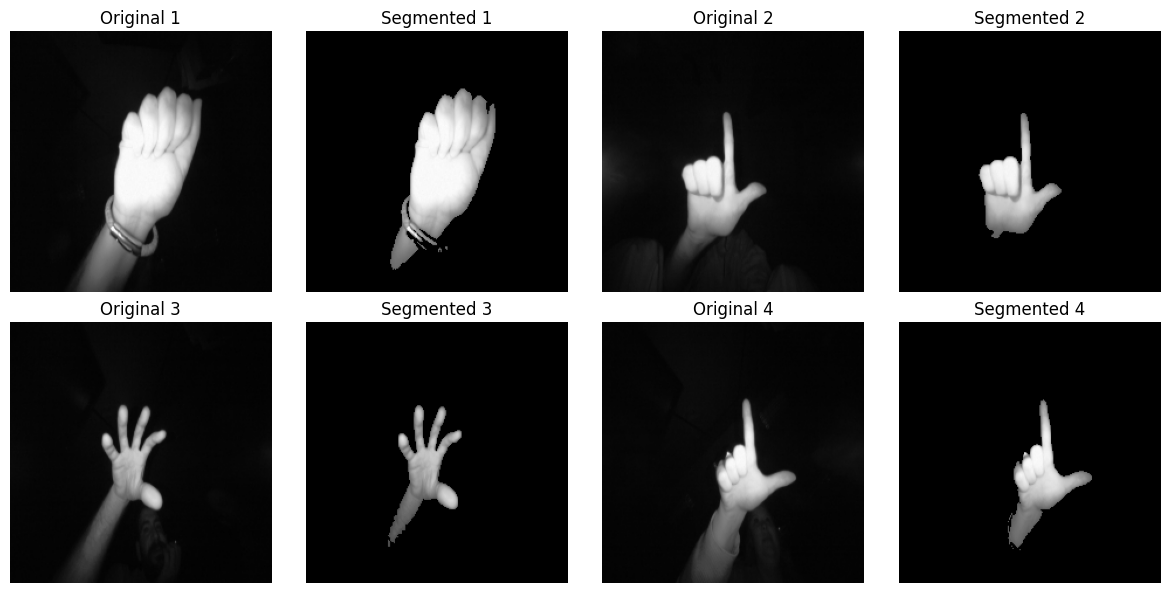

2025-10-02 03:34:16.694455: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
# Take one batch from training set
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 6))

    for i in range(4):  # Take the first 4 images
        sample_img = images[i]
        segmented_img = segment_hand(sample_img)

        # Row/col position:
        row = i // 2   # 0 or 1
        col = i % 2    # 0 or 1

        # Original
        plt.subplot(2, 4, row*4 + col*2 + 1)
        plt.imshow(sample_img.numpy().astype("uint8"), cmap="gray")
        plt.title(f"Original {i+1}")
        plt.axis("off")

        # Segmented
        plt.subplot(2, 4, row*4 + col*2 + 2)
        plt.imshow(segmented_img, cmap="gray")
        plt.title(f"Segmented {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [22]:
# Define the Normalization Layer
normalization_layer = layers.Rescaling(1./255)

In [23]:
# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
])

In [25]:
# Apply preprocessing to The Images
train_data = train_ds.map(lambda x, y: (normalization_layer(data_augmentation(x, training=True)), y))
val_data   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_data  = test_ds.map(lambda x, y: (normalization_layer(x), y))

***Image Preprocessing & Augmentation***

**Segmentation**  
We experimented with background subtraction / color-based segmentation to isolate the hand from the background. However, the images in our dataset already have clean backgrounds with minimal noise. Therefore, the segmented images looked very similar to the originals, and segmentation did not add significant benefit for training.

---

**Normalization**  
We applied normalization to scale pixel values from the range [0, 255] down to [0, 1]. This ensures more stable training and faster convergence.

---

**Data Augmentation**  
We applied data augmentation To increase dataset variability and reduce overfitting by creating modified versions of training images so the model can generalize better to unseen data.  

We used the following transformations:  
- **Random Flip (horizontal):** Helps the model learn that left/right orientations of the hand are equally valid.  
- **Random Rotation (0.1):** Introduces slight rotations to simulate natural variation in how hands appear.  
- **Random Zoom (0.1):** Covers different hand sizes or distances from the camera.  
- **Random Translation (0.1, 0.1):** Allows the model to handle shifts in hand position.  
- **Random Contrast (0.1):** Teaches the model to be able to handle different lighting conditions.